# Deep Q-learning or Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [14]:
# Actor-Critic/ D/Q
def D_target(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D_target', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [15]:
def model_loss(actions, states, targetQs, action_size, hidden_size, is_training):
    
    actions_logits = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                       is_training=is_training)
    actions_target = D_target(states=states, hidden_size=hidden_size, action_size=action_size, 
                              is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits, loss, actions_target

In [16]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('D')]
    d_vars_tgt = [var for var in t_vars if var.name.startswith('D_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=d_vars)
        
        opt_tgt = [d_vars_tgt[i].assign((d_vars_tgt[i]*gamma) + (d_vars[i]*(1 - gamma))) 
                   for i in range(len(d_vars_tgt))]

    return opt, opt_tgt

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma, tau):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.is_training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss, self.actions_target = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.opt, self.opt_target = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=tau)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [20]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20               # experience mini-batch size
gamma = 0.99                   # future reward discount
tau = 0.9999                   # target network discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
              learning_rate=learning_rate, gamma=gamma, tau=tau)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [22]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
def act(sess, state):
    
    action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                              model.is_training: False})
    
    action = np.argmax(action_logits, axis=1)[0]
    #print(action)
    
    return action

In [24]:
def learn(sess, memory, batch_size):
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    
    next_actions_target = sess.run(model.actions_target, feed_dict = {model.states: next_states, 
                                                                      model.is_training: False})
    
    nextQs = np.max(next_actions_target, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.is_training: False})
    
    sess.run(model.opt_target, feed_dict = {model.states: states,
                                            model.actions: actions,
                                            model.targetQs: targetQs, 
                                            model.is_training: False})
    return loss

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done)])
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                loss = learn(sess, memory, batch_size)
                loss_batch.append(loss)
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)
            
            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'loss:{:.4f}'.format(np.mean(loss_batch)),
                  'exploreP:{:.4f}'.format(explore_p))

            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:1 meanR:16.0000 R:16.0 loss:1.1166 exploreP:0.9971
Episode:2 meanR:15.5000 R:15.0 loss:1.0628 exploreP:0.9957
Episode:3 meanR:15.6667 R:16.0 loss:0.9569 exploreP:0.9941
Episode:4 meanR:18.2500 R:26.0 loss:0.8545 exploreP:0.9915
Episode:5 meanR:16.4000 R:9.0 loss:0.8056 exploreP:0.9906
Episode:6 meanR:16.3333 R:16.0 loss:0.7059 exploreP:0.9891
Episode:7 meanR:18.2857 R:30.0 loss:0.5699 exploreP:0.9861
Episode:8 meanR:17.5000 R:12.0 loss:0.4765 exploreP:0.9850
Episode:9 meanR:17.1111 R:14.0 loss:0.3967 exploreP:0.9836
Episode:10 meanR:17.0000 R:16.0 loss:0.3359 exploreP:0.9820
Episode:11 meanR:16.9091 R:16.0 loss:0.2819 exploreP:0.9805
Episode:12 meanR:16.6667 R:14.0 loss:0.2432 exploreP:0.9791
Episode:13 meanR:16.6923 R:17.0 loss:0.2083 exploreP:0.9775
Episode:14 meanR:16.5000 R:14.0 loss:0.1622 exploreP:0.9761
Episode:15 meanR:16.9333 R:23.0 loss:0.1184 exploreP:0.9739
Episode:16 meanR:18.7500 R:46.0 loss:0.0760 exploreP:0.9695
Episode:17 meanR:18.4706 R:14.0 loss:0.0574 explor

Episode:138 meanR:19.7800 R:30.0 loss:0.0024 exploreP:0.7642
Episode:139 meanR:19.6900 R:9.0 loss:0.0018 exploreP:0.7635
Episode:140 meanR:19.6600 R:16.0 loss:0.0022 exploreP:0.7623
Episode:141 meanR:19.6400 R:14.0 loss:0.0021 exploreP:0.7612
Episode:142 meanR:19.5200 R:11.0 loss:0.0017 exploreP:0.7604
Episode:143 meanR:19.5600 R:21.0 loss:0.0022 exploreP:0.7588
Episode:144 meanR:19.4100 R:16.0 loss:0.0017 exploreP:0.7576
Episode:145 meanR:19.4500 R:20.0 loss:0.0023 exploreP:0.7561
Episode:146 meanR:19.2800 R:15.0 loss:0.0021 exploreP:0.7550
Episode:147 meanR:19.2600 R:11.0 loss:0.0014 exploreP:0.7542
Episode:148 meanR:19.1600 R:12.0 loss:0.0023 exploreP:0.7533
Episode:149 meanR:19.0600 R:9.0 loss:0.0019 exploreP:0.7526
Episode:150 meanR:18.9800 R:12.0 loss:0.0023 exploreP:0.7517
Episode:151 meanR:18.6500 R:14.0 loss:0.0015 exploreP:0.7507
Episode:152 meanR:18.6600 R:15.0 loss:0.0021 exploreP:0.7496
Episode:153 meanR:18.5500 R:14.0 loss:0.0015 exploreP:0.7486
Episode:154 meanR:18.5900 

Episode:274 meanR:14.3800 R:13.0 loss:0.0020 exploreP:0.6289
Episode:275 meanR:14.3100 R:11.0 loss:0.0016 exploreP:0.6283
Episode:276 meanR:14.3400 R:15.0 loss:0.0022 exploreP:0.6273
Episode:277 meanR:14.3100 R:11.0 loss:0.0023 exploreP:0.6267
Episode:278 meanR:14.3100 R:15.0 loss:0.0023 exploreP:0.6257
Episode:279 meanR:14.3400 R:16.0 loss:0.0024 exploreP:0.6247
Episode:280 meanR:14.5100 R:32.0 loss:0.0019 exploreP:0.6228
Episode:281 meanR:14.5200 R:15.0 loss:0.0018 exploreP:0.6219
Episode:282 meanR:14.4900 R:13.0 loss:0.0026 exploreP:0.6211
Episode:283 meanR:14.4600 R:9.0 loss:0.0022 exploreP:0.6205
Episode:284 meanR:14.4800 R:14.0 loss:0.0019 exploreP:0.6197
Episode:285 meanR:14.4900 R:13.0 loss:0.0021 exploreP:0.6189
Episode:286 meanR:14.4400 R:15.0 loss:0.0026 exploreP:0.6180
Episode:287 meanR:14.3300 R:11.0 loss:0.0024 exploreP:0.6173
Episode:288 meanR:14.3200 R:11.0 loss:0.0016 exploreP:0.6166
Episode:289 meanR:14.3400 R:12.0 loss:0.0025 exploreP:0.6159
Episode:290 meanR:14.3000

Episode:410 meanR:12.6000 R:16.0 loss:0.0034 exploreP:0.5287
Episode:411 meanR:12.6200 R:13.0 loss:0.0033 exploreP:0.5280
Episode:412 meanR:12.5200 R:12.0 loss:0.0021 exploreP:0.5274
Episode:413 meanR:12.4400 R:13.0 loss:0.0039 exploreP:0.5267
Episode:414 meanR:12.4100 R:9.0 loss:0.0034 exploreP:0.5263
Episode:415 meanR:12.4000 R:12.0 loss:0.0035 exploreP:0.5256
Episode:416 meanR:12.4200 R:12.0 loss:0.0033 exploreP:0.5250
Episode:417 meanR:12.7300 R:39.0 loss:0.0032 exploreP:0.5230
Episode:418 meanR:12.7400 R:14.0 loss:0.0028 exploreP:0.5223
Episode:419 meanR:12.6800 R:10.0 loss:0.0029 exploreP:0.5218
Episode:420 meanR:12.8100 R:23.0 loss:0.0040 exploreP:0.5206
Episode:421 meanR:12.8300 R:17.0 loss:0.0045 exploreP:0.5197
Episode:422 meanR:12.8100 R:10.0 loss:0.0021 exploreP:0.5192
Episode:423 meanR:12.9900 R:28.0 loss:0.0029 exploreP:0.5178
Episode:424 meanR:12.9600 R:10.0 loss:0.0033 exploreP:0.5173
Episode:425 meanR:12.9400 R:9.0 loss:0.0034 exploreP:0.5168
Episode:426 meanR:12.9400 

Episode:548 meanR:13.2000 R:15.0 loss:0.0044 exploreP:0.4416
Episode:549 meanR:13.1600 R:13.0 loss:0.0040 exploreP:0.4410
Episode:550 meanR:13.1200 R:10.0 loss:0.0054 exploreP:0.4406
Episode:551 meanR:13.2200 R:20.0 loss:0.0040 exploreP:0.4398
Episode:552 meanR:13.2000 R:11.0 loss:0.0039 exploreP:0.4393
Episode:553 meanR:13.1900 R:11.0 loss:0.0063 exploreP:0.4388
Episode:554 meanR:13.2100 R:12.0 loss:0.0048 exploreP:0.4383
Episode:555 meanR:13.1900 R:9.0 loss:0.0053 exploreP:0.4379
Episode:556 meanR:13.1500 R:11.0 loss:0.0050 exploreP:0.4374
Episode:557 meanR:13.1600 R:13.0 loss:0.0053 exploreP:0.4369
Episode:558 meanR:13.1900 R:16.0 loss:0.0056 exploreP:0.4362
Episode:559 meanR:13.1700 R:11.0 loss:0.0044 exploreP:0.4357
Episode:560 meanR:13.2200 R:13.0 loss:0.0054 exploreP:0.4352
Episode:561 meanR:13.2600 R:14.0 loss:0.0048 exploreP:0.4346
Episode:562 meanR:13.2900 R:14.0 loss:0.0054 exploreP:0.4340
Episode:563 meanR:13.2500 R:10.0 loss:0.0057 exploreP:0.4336
Episode:564 meanR:13.2500

Episode:685 meanR:12.8100 R:14.0 loss:0.0085 exploreP:0.3724
Episode:686 meanR:12.7800 R:9.0 loss:0.0077 exploreP:0.3721
Episode:687 meanR:12.7600 R:10.0 loss:0.0074 exploreP:0.3717
Episode:688 meanR:12.7500 R:10.0 loss:0.0086 exploreP:0.3714
Episode:689 meanR:12.7300 R:9.0 loss:0.0084 exploreP:0.3710
Episode:690 meanR:12.6800 R:9.0 loss:0.0072 exploreP:0.3707
Episode:691 meanR:12.6700 R:10.0 loss:0.0066 exploreP:0.3704
Episode:692 meanR:12.6600 R:11.0 loss:0.0083 exploreP:0.3700
Episode:693 meanR:12.6500 R:9.0 loss:0.0091 exploreP:0.3696
Episode:694 meanR:12.6300 R:13.0 loss:0.0066 exploreP:0.3692
Episode:695 meanR:12.5400 R:9.0 loss:0.0073 exploreP:0.3689
Episode:696 meanR:12.4300 R:8.0 loss:0.0057 exploreP:0.3686
Episode:697 meanR:12.3400 R:14.0 loss:0.0086 exploreP:0.3681
Episode:698 meanR:12.2900 R:9.0 loss:0.0057 exploreP:0.3677
Episode:699 meanR:12.2800 R:8.0 loss:0.0064 exploreP:0.3675
Episode:700 meanR:12.2900 R:12.0 loss:0.0091 exploreP:0.3670
Episode:701 meanR:12.2400 R:12.0

Episode:824 meanR:11.7900 R:9.0 loss:0.0085 exploreP:0.3186
Episode:825 meanR:11.8100 R:14.0 loss:0.0117 exploreP:0.3182
Episode:826 meanR:11.7400 R:10.0 loss:0.0114 exploreP:0.3179
Episode:827 meanR:11.7400 R:10.0 loss:0.0094 exploreP:0.3176
Episode:828 meanR:11.6400 R:9.0 loss:0.0120 exploreP:0.3173
Episode:829 meanR:11.6300 R:10.0 loss:0.0099 exploreP:0.3170
Episode:830 meanR:11.5500 R:8.0 loss:0.0145 exploreP:0.3167
Episode:831 meanR:11.5300 R:9.0 loss:0.0115 exploreP:0.3165
Episode:832 meanR:11.6700 R:23.0 loss:0.0109 exploreP:0.3158
Episode:833 meanR:11.6400 R:10.0 loss:0.0094 exploreP:0.3155
Episode:834 meanR:11.6200 R:9.0 loss:0.0112 exploreP:0.3152
Episode:835 meanR:11.6100 R:9.0 loss:0.0086 exploreP:0.3149
Episode:836 meanR:11.5900 R:10.0 loss:0.0140 exploreP:0.3146
Episode:837 meanR:11.7400 R:24.0 loss:0.0080 exploreP:0.3139
Episode:838 meanR:11.7100 R:10.0 loss:0.0115 exploreP:0.3136
Episode:839 meanR:11.6500 R:8.0 loss:0.0078 exploreP:0.3133
Episode:840 meanR:11.7400 R:19.

Episode:961 meanR:11.4300 R:21.0 loss:0.0120 exploreP:0.2731
Episode:962 meanR:11.4600 R:14.0 loss:0.0143 exploreP:0.2728
Episode:963 meanR:11.4500 R:10.0 loss:0.0165 exploreP:0.2725
Episode:964 meanR:11.4200 R:9.0 loss:0.0096 exploreP:0.2723
Episode:965 meanR:11.4000 R:10.0 loss:0.0174 exploreP:0.2720
Episode:966 meanR:11.4600 R:17.0 loss:0.0133 exploreP:0.2716
Episode:967 meanR:11.4700 R:10.0 loss:0.0132 exploreP:0.2713
Episode:968 meanR:11.4400 R:10.0 loss:0.0116 exploreP:0.2710
Episode:969 meanR:11.3400 R:9.0 loss:0.0115 exploreP:0.2708
Episode:970 meanR:11.3600 R:11.0 loss:0.0116 exploreP:0.2705
Episode:971 meanR:11.3700 R:11.0 loss:0.0119 exploreP:0.2702
Episode:972 meanR:11.3500 R:10.0 loss:0.0170 exploreP:0.2700
Episode:973 meanR:11.3700 R:11.0 loss:0.0103 exploreP:0.2697
Episode:974 meanR:11.4100 R:13.0 loss:0.0149 exploreP:0.2694
Episode:975 meanR:11.3800 R:8.0 loss:0.0129 exploreP:0.2691
Episode:976 meanR:11.3600 R:9.0 loss:0.0143 exploreP:0.2689
Episode:977 meanR:11.3400 R:

Episode:1098 meanR:10.8700 R:10.0 loss:0.0136 exploreP:0.2369
Episode:1099 meanR:10.8800 R:10.0 loss:0.0170 exploreP:0.2367
Episode:1100 meanR:10.8700 R:10.0 loss:0.0190 exploreP:0.2365
Episode:1101 meanR:10.8500 R:8.0 loss:0.0155 exploreP:0.2363
Episode:1102 meanR:10.8500 R:10.0 loss:0.0168 exploreP:0.2361
Episode:1103 meanR:10.8600 R:11.0 loss:0.0209 exploreP:0.2358
Episode:1104 meanR:10.8400 R:9.0 loss:0.0204 exploreP:0.2356
Episode:1105 meanR:10.8600 R:19.0 loss:0.0128 exploreP:0.2352
Episode:1106 meanR:10.8700 R:10.0 loss:0.0144 exploreP:0.2350
Episode:1107 meanR:10.8800 R:10.0 loss:0.0113 exploreP:0.2348
Episode:1108 meanR:10.8400 R:9.0 loss:0.0127 exploreP:0.2346
Episode:1109 meanR:10.8500 R:10.0 loss:0.0157 exploreP:0.2343
Episode:1110 meanR:10.8300 R:9.0 loss:0.0193 exploreP:0.2341
Episode:1111 meanR:10.7800 R:9.0 loss:0.0141 exploreP:0.2339
Episode:1112 meanR:10.7200 R:10.0 loss:0.0126 exploreP:0.2337
Episode:1113 meanR:10.7500 R:13.0 loss:0.0117 exploreP:0.2334
Episode:1114 

Episode:1233 meanR:10.4100 R:11.0 loss:0.0257 exploreP:0.2069
Episode:1234 meanR:10.4300 R:11.0 loss:0.0240 exploreP:0.2067
Episode:1235 meanR:10.4300 R:11.0 loss:0.0234 exploreP:0.2064
Episode:1236 meanR:10.3700 R:15.0 loss:0.0142 exploreP:0.2062
Episode:1237 meanR:10.4100 R:13.0 loss:0.0149 exploreP:0.2059
Episode:1238 meanR:10.4100 R:10.0 loss:0.0149 exploreP:0.2057
Episode:1239 meanR:10.4100 R:9.0 loss:0.0133 exploreP:0.2055
Episode:1240 meanR:10.4400 R:12.0 loss:0.0145 exploreP:0.2053
Episode:1241 meanR:10.4100 R:8.0 loss:0.0191 exploreP:0.2051
Episode:1242 meanR:10.4100 R:10.0 loss:0.0159 exploreP:0.2049
Episode:1243 meanR:10.4100 R:9.0 loss:0.0230 exploreP:0.2048
Episode:1244 meanR:10.4100 R:11.0 loss:0.0240 exploreP:0.2046
Episode:1245 meanR:10.4100 R:10.0 loss:0.0209 exploreP:0.2044
Episode:1246 meanR:10.4300 R:10.0 loss:0.0164 exploreP:0.2042
Episode:1247 meanR:10.4200 R:9.0 loss:0.0203 exploreP:0.2040
Episode:1248 meanR:10.4500 R:12.0 loss:0.0234 exploreP:0.2038
Episode:1249

Episode:1370 meanR:10.2800 R:9.0 loss:0.0266 exploreP:0.1807
Episode:1371 meanR:10.3000 R:12.0 loss:0.0188 exploreP:0.1805
Episode:1372 meanR:10.3000 R:11.0 loss:0.0231 exploreP:0.1803
Episode:1373 meanR:10.3200 R:10.0 loss:0.0148 exploreP:0.1801
Episode:1374 meanR:10.3100 R:8.0 loss:0.0204 exploreP:0.1800
Episode:1375 meanR:10.3500 R:13.0 loss:0.0237 exploreP:0.1797
Episode:1376 meanR:10.3100 R:9.0 loss:0.0177 exploreP:0.1796
Episode:1377 meanR:10.3500 R:13.0 loss:0.0162 exploreP:0.1794
Episode:1378 meanR:10.3400 R:10.0 loss:0.0182 exploreP:0.1792
Episode:1379 meanR:10.3300 R:9.0 loss:0.0184 exploreP:0.1791
Episode:1380 meanR:10.3600 R:13.0 loss:0.0176 exploreP:0.1788
Episode:1381 meanR:10.3600 R:10.0 loss:0.0168 exploreP:0.1787
Episode:1382 meanR:10.3900 R:11.0 loss:0.0275 exploreP:0.1785
Episode:1383 meanR:10.4100 R:10.0 loss:0.0203 exploreP:0.1783
Episode:1384 meanR:10.4100 R:11.0 loss:0.0196 exploreP:0.1781
Episode:1385 meanR:10.3900 R:8.0 loss:0.0268 exploreP:0.1780
Episode:1386 

Episode:1507 meanR:10.2200 R:10.0 loss:0.0170 exploreP:0.1583
Episode:1508 meanR:10.2400 R:12.0 loss:0.0184 exploreP:0.1581
Episode:1509 meanR:10.2400 R:10.0 loss:0.0246 exploreP:0.1579
Episode:1510 meanR:10.2400 R:10.0 loss:0.0189 exploreP:0.1578
Episode:1511 meanR:10.2500 R:11.0 loss:0.0347 exploreP:0.1576
Episode:1512 meanR:10.2400 R:9.0 loss:0.0242 exploreP:0.1575
Episode:1513 meanR:10.2300 R:9.0 loss:0.0303 exploreP:0.1573
Episode:1514 meanR:10.2200 R:10.0 loss:0.0232 exploreP:0.1572
Episode:1515 meanR:10.2300 R:10.0 loss:0.0208 exploreP:0.1571
Episode:1516 meanR:10.2200 R:9.0 loss:0.0211 exploreP:0.1569
Episode:1517 meanR:10.2000 R:11.0 loss:0.0165 exploreP:0.1568
Episode:1518 meanR:10.2100 R:10.0 loss:0.0230 exploreP:0.1566
Episode:1519 meanR:10.2200 R:11.0 loss:0.0269 exploreP:0.1565
Episode:1520 meanR:10.2200 R:9.0 loss:0.0252 exploreP:0.1563
Episode:1521 meanR:10.1900 R:9.0 loss:0.0279 exploreP:0.1562
Episode:1522 meanR:10.1900 R:10.0 loss:0.0160 exploreP:0.1560
Episode:1523 

Episode:1642 meanR:10.3000 R:9.0 loss:0.0243 exploreP:0.1391
Episode:1643 meanR:10.3300 R:11.0 loss:0.0256 exploreP:0.1390
Episode:1644 meanR:10.3400 R:9.0 loss:0.0156 exploreP:0.1389
Episode:1645 meanR:10.3500 R:11.0 loss:0.0310 exploreP:0.1387
Episode:1646 meanR:10.3200 R:11.0 loss:0.0207 exploreP:0.1386
Episode:1647 meanR:10.3200 R:9.0 loss:0.0251 exploreP:0.1385
Episode:1648 meanR:10.2800 R:8.0 loss:0.0332 exploreP:0.1384
Episode:1649 meanR:10.2800 R:12.0 loss:0.0309 exploreP:0.1382
Episode:1650 meanR:10.2800 R:8.0 loss:0.0288 exploreP:0.1381
Episode:1651 meanR:10.2700 R:8.0 loss:0.0205 exploreP:0.1380
Episode:1652 meanR:10.2700 R:11.0 loss:0.0358 exploreP:0.1379
Episode:1653 meanR:10.2600 R:10.0 loss:0.0314 exploreP:0.1378
Episode:1654 meanR:10.2500 R:10.0 loss:0.0228 exploreP:0.1376
Episode:1655 meanR:10.2500 R:11.0 loss:0.0310 exploreP:0.1375
Episode:1656 meanR:10.2500 R:9.0 loss:0.0324 exploreP:0.1374
Episode:1657 meanR:10.2800 R:12.0 loss:0.0301 exploreP:0.1372
Episode:1658 me

Episode:1777 meanR:10.2900 R:12.0 loss:0.0274 exploreP:0.1225
Episode:1778 meanR:10.3400 R:15.0 loss:0.0281 exploreP:0.1223
Episode:1779 meanR:10.3100 R:9.0 loss:0.0179 exploreP:0.1222
Episode:1780 meanR:10.2800 R:9.0 loss:0.0424 exploreP:0.1221
Episode:1781 meanR:10.3100 R:12.0 loss:0.0324 exploreP:0.1220
Episode:1782 meanR:10.3100 R:10.0 loss:0.0162 exploreP:0.1219
Episode:1783 meanR:10.3100 R:9.0 loss:0.0248 exploreP:0.1218
Episode:1784 meanR:10.2800 R:9.0 loss:0.0237 exploreP:0.1217
Episode:1785 meanR:10.2700 R:9.0 loss:0.0264 exploreP:0.1216
Episode:1786 meanR:10.2600 R:9.0 loss:0.0250 exploreP:0.1215
Episode:1787 meanR:10.2800 R:11.0 loss:0.0172 exploreP:0.1214
Episode:1788 meanR:10.2800 R:10.0 loss:0.0261 exploreP:0.1213
Episode:1789 meanR:10.3000 R:11.0 loss:0.0260 exploreP:0.1211
Episode:1790 meanR:10.2900 R:9.0 loss:0.0315 exploreP:0.1210
Episode:1791 meanR:10.3000 R:9.0 loss:0.0189 exploreP:0.1209
Episode:1792 meanR:10.2900 R:9.0 loss:0.0301 exploreP:0.1208
Episode:1793 mean

Episode:1915 meanR:9.9800 R:11.0 loss:0.0250 exploreP:0.1081
Episode:1916 meanR:9.9700 R:9.0 loss:0.0346 exploreP:0.1080
Episode:1917 meanR:10.0100 R:13.0 loss:0.0236 exploreP:0.1078
Episode:1918 meanR:10.0100 R:9.0 loss:0.0229 exploreP:0.1077
Episode:1919 meanR:10.0100 R:10.0 loss:0.0375 exploreP:0.1077
Episode:1920 meanR:10.0200 R:9.0 loss:0.0238 exploreP:0.1076
Episode:1921 meanR:10.0000 R:9.0 loss:0.0259 exploreP:0.1075
Episode:1922 meanR:10.0000 R:10.0 loss:0.0274 exploreP:0.1074
Episode:1923 meanR:10.0200 R:11.0 loss:0.0262 exploreP:0.1073
Episode:1924 meanR:10.0200 R:10.0 loss:0.0225 exploreP:0.1072
Episode:1925 meanR:10.0100 R:8.0 loss:0.0232 exploreP:0.1071
Episode:1926 meanR:10.0400 R:12.0 loss:0.0302 exploreP:0.1070
Episode:1927 meanR:10.0400 R:9.0 loss:0.0259 exploreP:0.1069
Episode:1928 meanR:10.0400 R:10.0 loss:0.0271 exploreP:0.1068
Episode:1929 meanR:10.0200 R:8.0 loss:0.0312 exploreP:0.1067
Episode:1930 meanR:10.0000 R:8.0 loss:0.0234 exploreP:0.1066
Episode:1931 meanR

Episode:2052 meanR:9.8800 R:9.0 loss:0.0291 exploreP:0.0956
Episode:2053 meanR:9.8800 R:11.0 loss:0.0446 exploreP:0.0955
Episode:2054 meanR:9.8700 R:8.0 loss:0.0197 exploreP:0.0954
Episode:2055 meanR:9.8700 R:10.0 loss:0.0366 exploreP:0.0954
Episode:2056 meanR:9.8600 R:9.0 loss:0.0335 exploreP:0.0953
Episode:2057 meanR:9.8600 R:9.0 loss:0.0260 exploreP:0.0952
Episode:2058 meanR:9.8600 R:9.0 loss:0.0288 exploreP:0.0951
Episode:2059 meanR:9.8300 R:8.0 loss:0.0216 exploreP:0.0951
Episode:2060 meanR:9.8300 R:10.0 loss:0.0340 exploreP:0.0950
Episode:2061 meanR:9.8300 R:11.0 loss:0.0334 exploreP:0.0949
Episode:2062 meanR:9.8200 R:9.0 loss:0.0270 exploreP:0.0948
Episode:2063 meanR:9.8000 R:8.0 loss:0.0219 exploreP:0.0947
Episode:2064 meanR:9.7800 R:10.0 loss:0.0358 exploreP:0.0946
Episode:2065 meanR:9.7500 R:10.0 loss:0.0312 exploreP:0.0946
Episode:2066 meanR:9.7500 R:10.0 loss:0.0195 exploreP:0.0945
Episode:2067 meanR:9.7700 R:12.0 loss:0.0220 exploreP:0.0944
Episode:2068 meanR:9.7600 R:9.0 

Episode:2187 meanR:9.8600 R:9.0 loss:0.0228 exploreP:0.0849
Episode:2188 meanR:9.8600 R:9.0 loss:0.0346 exploreP:0.0848
Episode:2189 meanR:9.8500 R:9.0 loss:0.0275 exploreP:0.0847
Episode:2190 meanR:9.8200 R:8.0 loss:0.0222 exploreP:0.0847
Episode:2191 meanR:9.8100 R:11.0 loss:0.0318 exploreP:0.0846
Episode:2192 meanR:9.8100 R:9.0 loss:0.0225 exploreP:0.0845
Episode:2193 meanR:9.8100 R:10.0 loss:0.0305 exploreP:0.0845
Episode:2194 meanR:9.8000 R:9.0 loss:0.0261 exploreP:0.0844
Episode:2195 meanR:9.8000 R:10.0 loss:0.0346 exploreP:0.0843
Episode:2196 meanR:9.8100 R:11.0 loss:0.0260 exploreP:0.0842
Episode:2197 meanR:9.8200 R:13.0 loss:0.0374 exploreP:0.0841
Episode:2198 meanR:9.8200 R:9.0 loss:0.0177 exploreP:0.0841
Episode:2199 meanR:9.8200 R:9.0 loss:0.0310 exploreP:0.0840
Episode:2200 meanR:9.8300 R:10.0 loss:0.0221 exploreP:0.0839
Episode:2201 meanR:9.8400 R:11.0 loss:0.0336 exploreP:0.0839
Episode:2202 meanR:9.8200 R:8.0 loss:0.0281 exploreP:0.0838
Episode:2203 meanR:9.8100 R:9.0 l

Episode:2324 meanR:9.5900 R:8.0 loss:0.0289 exploreP:0.0756
Episode:2325 meanR:9.5900 R:10.0 loss:0.0325 exploreP:0.0755
Episode:2326 meanR:9.6200 R:11.0 loss:0.0334 exploreP:0.0755
Episode:2327 meanR:9.6300 R:11.0 loss:0.0262 exploreP:0.0754
Episode:2328 meanR:9.6300 R:9.0 loss:0.0281 exploreP:0.0753
Episode:2329 meanR:9.6300 R:9.0 loss:0.0292 exploreP:0.0753
Episode:2330 meanR:9.6300 R:9.0 loss:0.0340 exploreP:0.0752
Episode:2331 meanR:9.6400 R:10.0 loss:0.0305 exploreP:0.0751
Episode:2332 meanR:9.6200 R:8.0 loss:0.0354 exploreP:0.0751
Episode:2333 meanR:9.6300 R:10.0 loss:0.0248 exploreP:0.0750
Episode:2334 meanR:9.6500 R:11.0 loss:0.0244 exploreP:0.0750
Episode:2335 meanR:9.6500 R:10.0 loss:0.0283 exploreP:0.0749
Episode:2336 meanR:9.6400 R:10.0 loss:0.0291 exploreP:0.0748
Episode:2337 meanR:9.6300 R:10.0 loss:0.0241 exploreP:0.0748
Episode:2338 meanR:9.6300 R:10.0 loss:0.0229 exploreP:0.0747
Episode:2339 meanR:9.6300 R:8.0 loss:0.0274 exploreP:0.0746
Episode:2340 meanR:9.6300 R:9.

Episode:2463 meanR:9.8300 R:9.0 loss:0.0196 exploreP:0.0672
Episode:2464 meanR:9.8400 R:10.0 loss:0.0277 exploreP:0.0671
Episode:2465 meanR:9.8200 R:11.0 loss:0.0251 exploreP:0.0671
Episode:2466 meanR:9.8100 R:9.0 loss:0.0213 exploreP:0.0670
Episode:2467 meanR:9.8200 R:10.0 loss:0.0198 exploreP:0.0670
Episode:2468 meanR:9.8300 R:10.0 loss:0.0160 exploreP:0.0669
Episode:2469 meanR:9.8400 R:9.0 loss:0.0302 exploreP:0.0669
Episode:2470 meanR:9.8500 R:10.0 loss:0.0289 exploreP:0.0668
Episode:2471 meanR:9.8500 R:9.0 loss:0.0276 exploreP:0.0668
Episode:2472 meanR:9.8500 R:10.0 loss:0.0344 exploreP:0.0667
Episode:2473 meanR:9.8200 R:8.0 loss:0.0151 exploreP:0.0667
Episode:2474 meanR:9.8100 R:8.0 loss:0.0292 exploreP:0.0666
Episode:2475 meanR:9.8000 R:10.0 loss:0.0273 exploreP:0.0666
Episode:2476 meanR:9.8000 R:11.0 loss:0.0316 exploreP:0.0665
Episode:2477 meanR:9.8200 R:11.0 loss:0.0231 exploreP:0.0664
Episode:2478 meanR:9.8300 R:10.0 loss:0.0252 exploreP:0.0664
Episode:2479 meanR:9.8400 R:10

Episode:2598 meanR:10.5500 R:10.0 loss:0.0217 exploreP:0.0597
Episode:2599 meanR:10.5400 R:10.0 loss:0.0381 exploreP:0.0597
Episode:2600 meanR:10.5400 R:9.0 loss:0.0364 exploreP:0.0596
Episode:2601 meanR:10.5500 R:10.0 loss:0.0306 exploreP:0.0596
Episode:2602 meanR:10.5600 R:10.0 loss:0.0268 exploreP:0.0595
Episode:2603 meanR:10.5600 R:9.0 loss:0.0290 exploreP:0.0595
Episode:2604 meanR:10.5500 R:9.0 loss:0.0478 exploreP:0.0595
Episode:2605 meanR:10.5600 R:10.0 loss:0.0248 exploreP:0.0594
Episode:2606 meanR:10.5600 R:9.0 loss:0.0397 exploreP:0.0594
Episode:2607 meanR:10.5800 R:12.0 loss:0.0216 exploreP:0.0593
Episode:2608 meanR:10.5700 R:9.0 loss:0.0348 exploreP:0.0593
Episode:2609 meanR:10.5700 R:9.0 loss:0.0366 exploreP:0.0592
Episode:2610 meanR:10.5700 R:9.0 loss:0.0216 exploreP:0.0592
Episode:2611 meanR:10.5600 R:9.0 loss:0.0160 exploreP:0.0591
Episode:2612 meanR:10.5600 R:9.0 loss:0.0218 exploreP:0.0591
Episode:2613 meanR:10.5500 R:8.0 loss:0.0234 exploreP:0.0590
Episode:2614 meanR

Episode:2735 meanR:9.8300 R:10.0 loss:0.0205 exploreP:0.0535
Episode:2736 meanR:9.8400 R:11.0 loss:0.0413 exploreP:0.0535
Episode:2737 meanR:9.8500 R:9.0 loss:0.0348 exploreP:0.0534
Episode:2738 meanR:9.8900 R:14.0 loss:0.0373 exploreP:0.0534
Episode:2739 meanR:9.8800 R:9.0 loss:0.0680 exploreP:0.0533
Episode:2740 meanR:9.8800 R:10.0 loss:0.0300 exploreP:0.0533
Episode:2741 meanR:9.8900 R:10.0 loss:0.0350 exploreP:0.0532
Episode:2742 meanR:9.9000 R:11.0 loss:0.0248 exploreP:0.0532
Episode:2743 meanR:9.9100 R:10.0 loss:0.0257 exploreP:0.0531
Episode:2744 meanR:9.9000 R:8.0 loss:0.0295 exploreP:0.0531
Episode:2745 meanR:9.9100 R:9.0 loss:0.0177 exploreP:0.0531
Episode:2746 meanR:9.8800 R:8.0 loss:0.0312 exploreP:0.0530
Episode:2747 meanR:9.8800 R:10.0 loss:0.0284 exploreP:0.0530
Episode:2748 meanR:9.8800 R:10.0 loss:0.0294 exploreP:0.0529
Episode:2749 meanR:9.8900 R:10.0 loss:0.0245 exploreP:0.0529
Episode:2750 meanR:9.9000 R:10.0 loss:0.0171 exploreP:0.0529
Episode:2751 meanR:9.9100 R:1

Episode:2872 meanR:10.2100 R:9.0 loss:0.0311 exploreP:0.0479
Episode:2873 meanR:10.2100 R:10.0 loss:0.0384 exploreP:0.0479
Episode:2874 meanR:10.2000 R:9.0 loss:0.0405 exploreP:0.0478
Episode:2875 meanR:10.2200 R:11.0 loss:0.0278 exploreP:0.0478
Episode:2876 meanR:10.2400 R:11.0 loss:0.0228 exploreP:0.0477
Episode:2877 meanR:10.2700 R:12.0 loss:0.0267 exploreP:0.0477
Episode:2878 meanR:10.2500 R:9.0 loss:0.0365 exploreP:0.0477
Episode:2879 meanR:10.2600 R:11.0 loss:0.0285 exploreP:0.0476
Episode:2880 meanR:10.2500 R:9.0 loss:0.0297 exploreP:0.0476
Episode:2881 meanR:10.2400 R:10.0 loss:0.0269 exploreP:0.0476
Episode:2882 meanR:10.2500 R:10.0 loss:0.0264 exploreP:0.0475
Episode:2883 meanR:10.2300 R:9.0 loss:0.0241 exploreP:0.0475
Episode:2884 meanR:10.2200 R:9.0 loss:0.0246 exploreP:0.0474
Episode:2885 meanR:10.2100 R:11.0 loss:0.0293 exploreP:0.0474
Episode:2886 meanR:10.1900 R:8.0 loss:0.0400 exploreP:0.0474
Episode:2887 meanR:10.1800 R:10.0 loss:0.0301 exploreP:0.0473
Episode:2888 me

Episode:3008 meanR:12.5100 R:12.0 loss:0.0325 exploreP:0.0419
Episode:3009 meanR:12.5300 R:11.0 loss:0.0323 exploreP:0.0419
Episode:3010 meanR:12.5500 R:12.0 loss:0.0371 exploreP:0.0418
Episode:3011 meanR:13.0800 R:63.0 loss:0.0239 exploreP:0.0416
Episode:3012 meanR:13.3900 R:40.0 loss:0.0331 exploreP:0.0415
Episode:3013 meanR:13.4100 R:11.0 loss:0.0220 exploreP:0.0415
Episode:3014 meanR:13.3900 R:10.0 loss:0.0337 exploreP:0.0415
Episode:3015 meanR:13.4100 R:12.0 loss:0.0440 exploreP:0.0414
Episode:3016 meanR:13.4400 R:13.0 loss:0.0233 exploreP:0.0414
Episode:3017 meanR:13.4400 R:11.0 loss:0.0263 exploreP:0.0413
Episode:3018 meanR:13.2800 R:12.0 loss:0.0191 exploreP:0.0413
Episode:3019 meanR:13.2700 R:11.0 loss:0.0347 exploreP:0.0413
Episode:3020 meanR:13.2600 R:11.0 loss:0.0331 exploreP:0.0412
Episode:3021 meanR:13.2800 R:13.0 loss:0.0375 exploreP:0.0412
Episode:3022 meanR:13.2800 R:10.0 loss:0.0389 exploreP:0.0412
Episode:3023 meanR:13.2800 R:10.0 loss:0.0210 exploreP:0.0411
Episode:

Episode:3141 meanR:20.4600 R:39.0 loss:0.0529 exploreP:0.0348
Episode:3142 meanR:19.9000 R:9.0 loss:0.0342 exploreP:0.0348
Episode:3143 meanR:19.8700 R:9.0 loss:0.0580 exploreP:0.0348
Episode:3144 meanR:19.8900 R:12.0 loss:0.0329 exploreP:0.0348
Episode:3145 meanR:19.8800 R:9.0 loss:0.0597 exploreP:0.0347
Episode:3146 meanR:19.8900 R:10.0 loss:0.0293 exploreP:0.0347
Episode:3147 meanR:19.9000 R:12.0 loss:0.0534 exploreP:0.0347
Episode:3148 meanR:19.3500 R:28.0 loss:0.0434 exploreP:0.0346
Episode:3149 meanR:19.3500 R:11.0 loss:0.0432 exploreP:0.0346
Episode:3150 meanR:19.3500 R:28.0 loss:0.0375 exploreP:0.0345
Episode:3151 meanR:19.7300 R:51.0 loss:0.0386 exploreP:0.0344
Episode:3152 meanR:19.7400 R:30.0 loss:0.0391 exploreP:0.0343
Episode:3153 meanR:19.9400 R:31.0 loss:0.0470 exploreP:0.0342
Episode:3154 meanR:20.1200 R:28.0 loss:0.0379 exploreP:0.0342
Episode:3155 meanR:20.3000 R:28.0 loss:0.0375 exploreP:0.0341
Episode:3156 meanR:20.3000 R:10.0 loss:0.0457 exploreP:0.0341
Episode:315

Episode:3273 meanR:102.5900 R:107.0 loss:0.0385 exploreP:0.0182
Episode:3274 meanR:103.5800 R:142.0 loss:0.0414 exploreP:0.0181
Episode:3275 meanR:104.6600 R:118.0 loss:0.0392 exploreP:0.0180
Episode:3276 meanR:105.8000 R:125.0 loss:0.0390 exploreP:0.0179
Episode:3277 meanR:106.9900 R:131.0 loss:0.0369 exploreP:0.0178
Episode:3278 meanR:107.3700 R:125.0 loss:0.0491 exploreP:0.0177
Episode:3279 meanR:108.4900 R:125.0 loss:0.0381 exploreP:0.0176
Episode:3280 meanR:108.9800 R:129.0 loss:0.0473 exploreP:0.0175
Episode:3281 meanR:109.2400 R:119.0 loss:0.0422 exploreP:0.0174
Episode:3282 meanR:109.7800 R:146.0 loss:0.0413 exploreP:0.0173
Episode:3283 meanR:110.5600 R:128.0 loss:0.0464 exploreP:0.0172
Episode:3284 meanR:110.8300 R:132.0 loss:0.0438 exploreP:0.0171
Episode:3285 meanR:111.5400 R:130.0 loss:0.0514 exploreP:0.0170
Episode:3286 meanR:112.4500 R:174.0 loss:0.0467 exploreP:0.0169
Episode:3287 meanR:113.5900 R:128.0 loss:0.0431 exploreP:0.0168
Episode:3288 meanR:114.2100 R:144.0 loss

Episode:3402 meanR:173.5300 R:197.0 loss:0.0727 exploreP:0.0110
Episode:3403 meanR:173.8700 R:186.0 loss:0.0628 exploreP:0.0109
Episode:3404 meanR:174.4100 R:212.0 loss:0.0484 exploreP:0.0109
Episode:3405 meanR:174.7800 R:188.0 loss:0.0629 exploreP:0.0109
Episode:3406 meanR:175.1800 R:203.0 loss:0.0463 exploreP:0.0109
Episode:3407 meanR:175.6700 R:198.0 loss:0.0559 exploreP:0.0109
Episode:3408 meanR:175.9200 R:189.0 loss:0.0488 exploreP:0.0109
Episode:3409 meanR:176.3000 R:190.0 loss:0.0545 exploreP:0.0108
Episode:3410 meanR:176.9100 R:203.0 loss:0.0871 exploreP:0.0108
Episode:3411 meanR:177.2200 R:185.0 loss:0.0596 exploreP:0.0108
Episode:3412 meanR:177.3000 R:185.0 loss:0.0682 exploreP:0.0108
Episode:3413 meanR:177.3700 R:176.0 loss:0.0488 exploreP:0.0108
Episode:3414 meanR:177.9400 R:217.0 loss:0.0742 exploreP:0.0108
Episode:3415 meanR:178.1800 R:188.0 loss:0.0712 exploreP:0.0107
Episode:3416 meanR:178.1600 R:166.0 loss:0.0682 exploreP:0.0107
Episode:3417 meanR:178.1200 R:163.0 loss

Episode:3531 meanR:178.8100 R:179.0 loss:0.0943 exploreP:0.0101
Episode:3532 meanR:179.1500 R:189.0 loss:0.0912 exploreP:0.0101
Episode:3533 meanR:179.1500 R:188.0 loss:0.1040 exploreP:0.0101
Episode:3534 meanR:179.4100 R:229.0 loss:0.0778 exploreP:0.0101
Episode:3535 meanR:179.4400 R:166.0 loss:0.0847 exploreP:0.0101
Episode:3536 meanR:179.2500 R:161.0 loss:0.0821 exploreP:0.0101
Episode:3537 meanR:179.3200 R:197.0 loss:0.0965 exploreP:0.0101
Episode:3538 meanR:179.3100 R:154.0 loss:0.1014 exploreP:0.0101
Episode:3539 meanR:179.9000 R:229.0 loss:0.0877 exploreP:0.0101
Episode:3540 meanR:180.3500 R:235.0 loss:0.0943 exploreP:0.0101
Episode:3541 meanR:180.5200 R:180.0 loss:0.1075 exploreP:0.0101
Episode:3542 meanR:180.8700 R:193.0 loss:0.0936 exploreP:0.0101
Episode:3543 meanR:180.8200 R:184.0 loss:0.0895 exploreP:0.0101
Episode:3544 meanR:181.4100 R:206.0 loss:0.0675 exploreP:0.0101
Episode:3545 meanR:181.1900 R:172.0 loss:0.0946 exploreP:0.0101
Episode:3546 meanR:181.9700 R:264.0 loss

Episode:3660 meanR:180.6300 R:192.0 loss:0.1621 exploreP:0.0100
Episode:3661 meanR:180.5500 R:186.0 loss:0.1166 exploreP:0.0100
Episode:3662 meanR:180.1700 R:177.0 loss:0.1427 exploreP:0.0100
Episode:3663 meanR:179.8900 R:157.0 loss:0.1284 exploreP:0.0100
Episode:3664 meanR:179.6100 R:165.0 loss:0.1303 exploreP:0.0100
Episode:3665 meanR:179.5500 R:183.0 loss:0.1431 exploreP:0.0100
Episode:3666 meanR:179.1500 R:163.0 loss:0.1389 exploreP:0.0100
Episode:3667 meanR:179.6700 R:219.0 loss:0.0930 exploreP:0.0100
Episode:3668 meanR:180.3200 R:232.0 loss:0.1736 exploreP:0.0100
Episode:3669 meanR:180.6000 R:189.0 loss:0.1564 exploreP:0.0100
Episode:3670 meanR:180.6500 R:161.0 loss:0.1450 exploreP:0.0100
Episode:3671 meanR:180.4100 R:176.0 loss:0.1259 exploreP:0.0100
Episode:3672 meanR:180.3400 R:173.0 loss:0.1369 exploreP:0.0100
Episode:3673 meanR:180.4000 R:170.0 loss:0.1021 exploreP:0.0100
Episode:3674 meanR:180.2800 R:150.0 loss:0.1032 exploreP:0.0100
Episode:3675 meanR:180.3500 R:183.0 loss

Episode:3789 meanR:181.5100 R:184.0 loss:0.0878 exploreP:0.0100
Episode:3790 meanR:181.7600 R:186.0 loss:0.0753 exploreP:0.0100
Episode:3791 meanR:181.8100 R:182.0 loss:0.0722 exploreP:0.0100
Episode:3792 meanR:181.8500 R:179.0 loss:0.1116 exploreP:0.0100
Episode:3793 meanR:181.6000 R:160.0 loss:0.0724 exploreP:0.0100
Episode:3794 meanR:181.5700 R:164.0 loss:0.0715 exploreP:0.0100
Episode:3795 meanR:181.6900 R:189.0 loss:0.0976 exploreP:0.0100
Episode:3796 meanR:181.6100 R:178.0 loss:0.1103 exploreP:0.0100
Episode:3797 meanR:181.2600 R:173.0 loss:0.0922 exploreP:0.0100
Episode:3798 meanR:181.5900 R:223.0 loss:0.0908 exploreP:0.0100
Episode:3799 meanR:181.5700 R:199.0 loss:0.0966 exploreP:0.0100
Episode:3800 meanR:181.0300 R:168.0 loss:0.1364 exploreP:0.0100
Episode:3801 meanR:181.2200 R:176.0 loss:0.0946 exploreP:0.0100
Episode:3802 meanR:181.3900 R:209.0 loss:0.0739 exploreP:0.0100
Episode:3803 meanR:181.0800 R:152.0 loss:0.0944 exploreP:0.0100
Episode:3804 meanR:181.0500 R:173.0 loss

Episode:3918 meanR:183.0200 R:167.0 loss:0.0382 exploreP:0.0100
Episode:3919 meanR:182.8100 R:169.0 loss:0.0316 exploreP:0.0100
Episode:3920 meanR:182.7600 R:162.0 loss:0.0302 exploreP:0.0100
Episode:3921 meanR:182.5500 R:169.0 loss:0.0350 exploreP:0.0100
Episode:3922 meanR:182.1300 R:158.0 loss:0.0361 exploreP:0.0100
Episode:3923 meanR:182.2900 R:191.0 loss:0.0290 exploreP:0.0100
Episode:3924 meanR:182.5600 R:226.0 loss:0.0373 exploreP:0.0100
Episode:3925 meanR:182.3300 R:181.0 loss:0.0307 exploreP:0.0100
Episode:3926 meanR:182.5500 R:186.0 loss:0.0469 exploreP:0.0100
Episode:3927 meanR:183.7900 R:293.0 loss:0.0267 exploreP:0.0100
Episode:3928 meanR:184.9800 R:291.0 loss:0.0283 exploreP:0.0100
Episode:3929 meanR:184.7300 R:158.0 loss:0.0257 exploreP:0.0100
Episode:3930 meanR:185.1500 R:210.0 loss:0.0726 exploreP:0.0100
Episode:3931 meanR:185.0400 R:160.0 loss:0.0336 exploreP:0.0100
Episode:3932 meanR:184.9900 R:153.0 loss:0.1012 exploreP:0.0100
Episode:3933 meanR:185.4400 R:226.0 loss

Episode:4047 meanR:135.7100 R:54.0 loss:0.1325 exploreP:0.0100
Episode:4048 meanR:134.4100 R:38.0 loss:0.4318 exploreP:0.0100
Episode:4049 meanR:133.6000 R:89.0 loss:0.1874 exploreP:0.0100
Episode:4050 meanR:132.2900 R:43.0 loss:0.1800 exploreP:0.0100
Episode:4051 meanR:131.3400 R:61.0 loss:0.0349 exploreP:0.0100
Episode:4052 meanR:130.2600 R:57.0 loss:0.0154 exploreP:0.0100
Episode:4053 meanR:128.5700 R:97.0 loss:0.0227 exploreP:0.0100
Episode:4054 meanR:127.3100 R:87.0 loss:0.1790 exploreP:0.0100
Episode:4055 meanR:126.9600 R:60.0 loss:0.0211 exploreP:0.0100
Episode:4056 meanR:125.8000 R:51.0 loss:0.0225 exploreP:0.0100
Episode:4057 meanR:123.6700 R:44.0 loss:0.1631 exploreP:0.0100
Episode:4058 meanR:122.5800 R:49.0 loss:0.0250 exploreP:0.0100
Episode:4059 meanR:121.3000 R:63.0 loss:0.0149 exploreP:0.0100
Episode:4060 meanR:120.5200 R:81.0 loss:0.1130 exploreP:0.0100
Episode:4061 meanR:119.0500 R:66.0 loss:0.0169 exploreP:0.0100
Episode:4062 meanR:118.1000 R:72.0 loss:0.2233 exploreP

Episode:4176 meanR:175.3600 R:277.0 loss:0.0936 exploreP:0.0100
Episode:4177 meanR:176.2500 R:208.0 loss:0.2042 exploreP:0.0100
Episode:4178 meanR:176.5800 R:211.0 loss:0.2133 exploreP:0.0100
Episode:4179 meanR:177.2700 R:190.0 loss:0.1123 exploreP:0.0100
Episode:4180 meanR:178.1500 R:269.0 loss:0.1430 exploreP:0.0100
Episode:4181 meanR:179.1900 R:223.0 loss:0.1091 exploreP:0.0100
Episode:4182 meanR:180.5300 R:265.0 loss:0.1020 exploreP:0.0100
Episode:4183 meanR:181.5900 R:236.0 loss:0.1818 exploreP:0.0100
Episode:4184 meanR:182.7100 R:179.0 loss:0.1261 exploreP:0.0100
Episode:4185 meanR:183.9500 R:191.0 loss:0.1174 exploreP:0.0100
Episode:4186 meanR:185.2500 R:227.0 loss:0.1546 exploreP:0.0100
Episode:4187 meanR:185.2300 R:179.0 loss:0.1178 exploreP:0.0100
Episode:4188 meanR:187.4000 R:275.0 loss:0.0786 exploreP:0.0100
Episode:4189 meanR:188.7700 R:183.0 loss:0.1320 exploreP:0.0100
Episode:4190 meanR:190.2400 R:219.0 loss:0.1283 exploreP:0.0100
Episode:4191 meanR:191.9600 R:263.0 loss

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

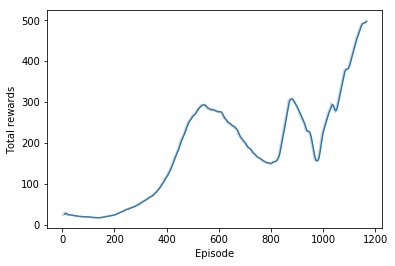

In [33]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

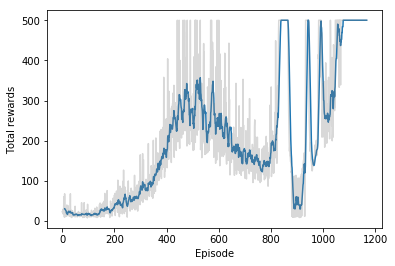

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Losses')

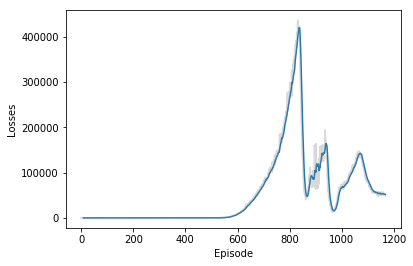

In [35]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.